In [1]:
from utils import *
import matplotlib.pyplot as plt
import pytesseract
%matplotlib inline

# **Download Dataset from Roboflow**

In [2]:
download_dataset('./data/tf-record-datasets', 'capstone-foodlabel', 4, "tfrecord")

loading Roboflow workspace...
loading Roboflow project...


# **Trained Model**

In [3]:
# load the models
model = get_model("./runs/detect/train7/weights/best.pt")

# **Examples**

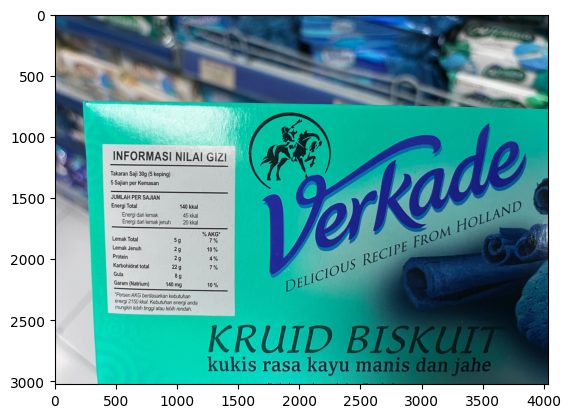

In [4]:
example = './data/datasets/test/images/IMG_3547_png.rf.222759c4068f3af1518b113912d91a5d.jpg'

image = cv2.imread(example)
plt.imshow(image)

In [5]:
prediction = model.predict(example)
x1, y1, x2, y2 = get_bounding_boxes(prediction)

print(f"---\nx1: {x1}\nx2: {x2}\ny1: {y1}\ny2: {y2}")


image 1/1 /Users/mafiefa/Projects/machine-learning-kaisar/data/datasets/test/images/IMG_3547_png.rf.222759c4068f3af1518b113912d91a5d.jpg: 480x640 1 nutrition-label, 152.0ms
Speed: 11.2ms preprocess, 152.0ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 640)
---
x1: 388.7062072753906
x2: 1468.97607421875
y1: 1070.8021240234375
y2: 2468.329345703125


In [6]:
image_cropped = crop(image, (x1, y1, x2, y2))
image_preprocessed = preprocess_for_ocr(image_cropped, enhance=2)

In [7]:
config = '--psm 0'
pytesseract.image_to_string(image_preprocessed, lang='ind', config='--psm 4')

'INFORMASI NILAI Gizi\n\nTakaran Saji 30g (5 keping)\n\n5 Sajian per Kemasan\nJUMLAH PER SAJIAN\nEnergi Total 140 kkal\nEnergi dari lemak 45 kkal\nEnergi dari lemak jenuh 20 kkal\nYo AKG"\nLemak Total 5g 1 Yo\nLemak Jenuh 2g 10 Yo\nProtein 2g 4 Yo\nKarbohidrat total 2g 1 Yo\nGula 8g\nGaram (Natrium) 140 mg 10 Yo\nang Ae GO Ml\n\n"Persen AKG berdasarkan kebutuhan\nenergi 2150 kkal, Kebutuhan energi anda\nmungkin lebih tinggi atau lebih rendah.\n'

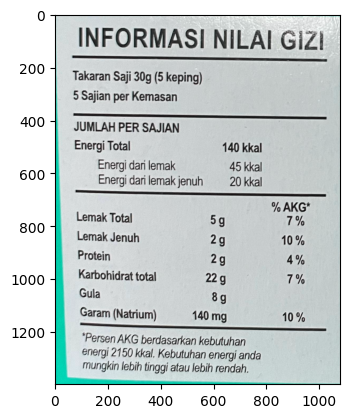

In [8]:
plt.imshow(image_cropped)

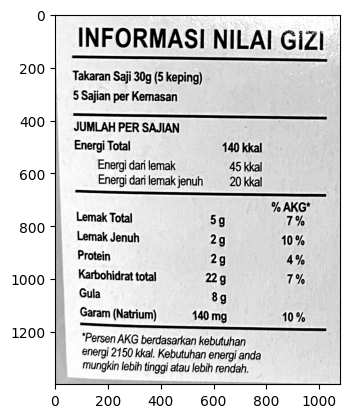

In [9]:
plt.imshow(image_preprocessed)

In [10]:
config = '-l ind --psm 4 --oem 1'
text_data = pytesseract.image_to_string(image_preprocessed, config=config)

In [11]:
cleaned_data = []
for data in text_data.split("\n"):
    data = clean_string(data)
    cleaned_data.append(data)

print(text_data)

print("--- cleaned ---")

for data in cleaned_data:
    print(data)

INFORMASI NILAI Gizi

Takaran Saji 30g (5 keping)

5 Sajian per Kemasan
JUMLAH PER SAJIAN
Energi Total 140 kkal
Energi dari lemak 45 kkal
Energi dari lemak jenuh 20 kkal
Yo AKG"
Lemak Total 5g 1 Yo
Lemak Jenuh 2g 10 Yo
Protein 2g 4 Yo
Karbohidrat total 2g 1 Yo
Gula 8g
Garam (Natrium) 140 mg 10 Yo
ang Ae GO Ml

"Persen AKG berdasarkan kebutuhan
energi 2150 kkal, Kebutuhan energi anda
mungkin lebih tinggi atau lebih rendah.

--- cleaned ---
INFORMASI NILAI Gizi

Takaran Saji 30g (5keping)

5Sajian per Kemasan
JUMLAH PER SAJIAN
Energi Total 140kkal
Energi dari lemak 45kkal
Energi dari lemak jenuh 20kkal
Yo AKG
Lemak Total 5g 1Yo
Lemak Jenuh 2g 10Yo
Protein 2g 4Yo
Karbohidrat total 2g 1Yo
Gula 8g
Garam (Natrium) 140mg 10Yo
ang Ae GO Ml

Persen AKG berdasarkan kebutuhan
energi 2150kkal, Kebutuhan energi anda
mungkin lebih tinggi atau lebih rendah.



In [12]:
nutrients_list = make_list('./data/nutrients.txt')

print(nutrients_list)

['Lemak', 'Fat', 'Karbohidrat', 'Carbohydrate', 'Gula', 'Sugar', 'Vitamin', 'Protein', 'Garam', 'Natrium', 'Salt', 'Sodium', 'Serat', 'Fiber', 'Kalori', 'Calories', 'Calorie', 'Kolesterol', 'Cholesterol', 'Iron', 'Besi', 'Potassium', 'Kalium', 'Kalsium', 'Calcium', 'Mineral']


In [13]:
cleaned = []
for data in cleaned_data:
    nutrient, value = get_label_from_string(data)
    for nutrient_val in nutrients_list:
        nutrient_val = nutrient_val.lower()
        if nutrient_val in nutrient.lower().split(" "):
            if type(separate_unit(value)) == tuple:
                cleaned.append((nutrient, separate_unit(value)))

cleaned = list(dict.fromkeys(cleaned))

print(cleaned)

[('Lemak Total', (5.0, 'g')), ('Lemak Jenuh', (2.0, 'g')), ('Protein Yo', (2.0, 'g')), ('Karbohidrat Yo', (2.0, 'g')), ('Gula', (8.0, 'g')), ('Garam Natrium', (140.0, 'mg'))]


In [14]:
print(to_nutritional_dict(label_value_list=cleaned))

{'karbohidrat': [(2.0, 'g')], 'gula': [(8.0, 'g')], 'protein': [(2.0, 'g')], 'vitamin': [], 'lemak': [(5.0, 'g'), (2.0, 'g')], 'garam': [(140.0, 'mg')], 'kalori': [], 'serat': [], 'kolesterol': [], 'mineral': []}
